# MNIST CLASSIFICATION

### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

### Fetching dataset

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False)

### Exploring dataset

In [4]:
mnist.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [5]:
mnist.target

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

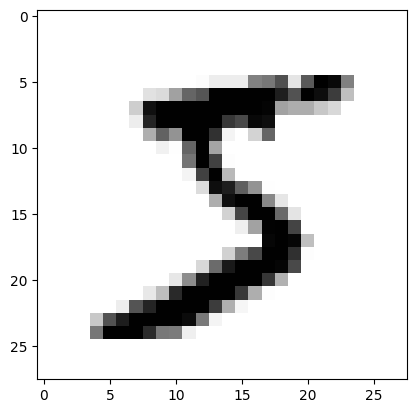

In [6]:
image = mnist.data[0].reshape(28,28)
plt.imshow(image, cmap='binary')
plt.show()

In [7]:
mnist.target[0]

'5'

### Creating training and test sets

In [8]:
# MNIST dataset is already split into training set (first 60000) and test set (last 10000)
X_train, X_test = mnist.data[:60000], mnist.data[60000:]
y_train, y_test = mnist.target[:60000], mnist.target[60000:] 

### Binary Classifier

In [9]:
y_train_0 = y_train == '0'
y_test_0 = y_test == '0'

#### Stochastic Gradient Descent Classifier

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_0)

zero = mnist.data[1]
sgd_clf.predict([zero])

array([ True])

In [11]:
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([0.9854, 0.9847, 0.9865])

In [12]:
dummy_clf = DummyClassifier(random_state=42)
cross_val_score(dummy_clf, X_train, y_train_0, cv=3, scoring='accuracy')

array([0.9013 , 0.9013 , 0.90125])

In [13]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)
y_train_pred

array([False,  True, False, ..., False, False, False], shape=(60000,))

#### Precision and recall

In [14]:
confusion_matrix(y_train_0, y_train_pred)

array([[53486,   591],
       [  277,  5646]])

In [15]:
precision_score(y_train_0, y_train_pred)

0.9052429052429053

In [16]:
recall_score(y_train_0, y_train_pred)

0.9532331588721932

In [17]:
f1_score(y_train_0, y_train_pred)

0.9286184210526316

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3, method='decision_function')
y_scores

array([-24790.155884  ,  31562.50035756, -23872.95718613, ...,
       -28606.46843279, -19778.55970938, -11683.52453461], shape=(60000,))

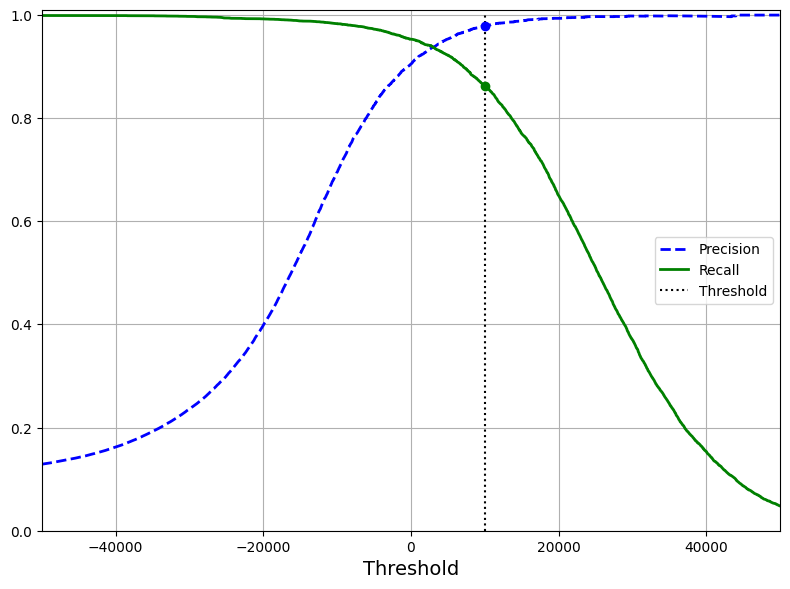

In [19]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
threshold = 10000

threshold_idx = np.argmin(np.abs(thresholds - threshold))

precision_at_threshold = precisions[threshold_idx]
recall_at_threshold = recalls[threshold_idx]

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k','dotted', label='Threshold')

plt.plot(threshold, precision_at_threshold, 'bo')
plt.plot(threshold, recall_at_threshold, 'go')

plt.xlim(-50000, 50000)
plt.ylim(0.0, 1.01)
plt.xlabel(xlabel='Threshold', size=14)
plt.grid()
plt.legend(loc='center right')
plt.tight_layout()
plt.show()

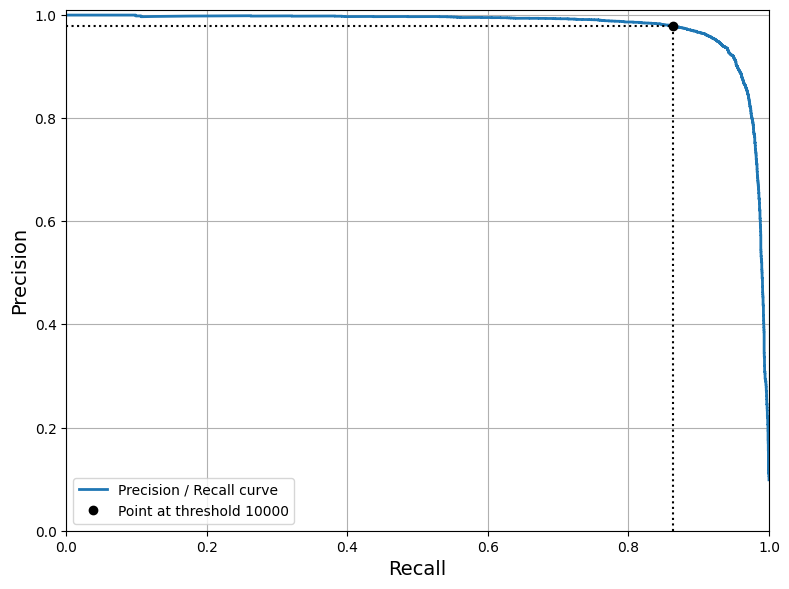

In [20]:
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, linewidth=2, label='Precision / Recall curve')

plt.vlines(recall_at_threshold, 0, precision_at_threshold, 'k','dotted')
plt.hlines(precision_at_threshold, 0, recall_at_threshold, 'k','dotted')
plt.plot(recall_at_threshold, precision_at_threshold, 'ko', label=f'Point at threshold {threshold}')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.01)
plt.xlabel(xlabel='Recall', size=14)
plt.ylabel(ylabel='Precision', size=14)
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [21]:
idx_for_95_precision = (precisions >= 0.95).argmax()
threshold_for_95_precision = thresholds[idx_for_95_precision]

y_train_95_precision = (y_scores >= threshold_for_95_precision)

precision_score(y_train_0, y_train_95_precision)

0.9501039501039501

In [22]:
recall_score(y_train_0, y_train_95_precision)

0.9258821543136924

#### Receiver operating characteristic (ROC)

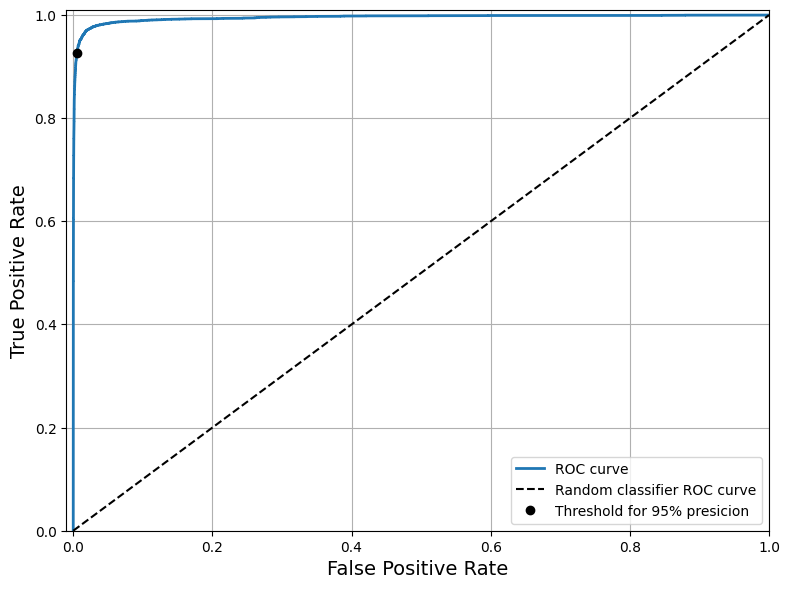

In [23]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

idx_for_threshold_at_95 = (thresholds <= threshold_for_95_precision).argmax()

fpr_95, tpr_95 = fpr[idx_for_threshold_at_95], tpr[idx_for_threshold_at_95]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0,1], [0,1], 'k--', label='Random classifier ROC curve')
plt.plot([fpr_95], [tpr_95], 'ko', label='Threshold for 95% presicion')

plt.xlim(-0.01, 1.0)
plt.ylim(0.0, 1.01)
plt.xlabel(xlabel='False Positive Rate', size=14)
plt.ylabel(ylabel='True Positive Rate', size=14)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [24]:
roc_auc_score(y_train_0, y_scores)

0.9951089652363219

#### Random Forest Classifier

In [25]:
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_0, cv=3, method='predict_proba')
y_probas_forest

array([[1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.99, 0.01]], shape=(60000, 2))

In [26]:
y_scores_forest = y_probas_forest[:,1]
y_scores_forest

array([0.  , 1.  , 0.  , ..., 0.  , 0.05, 0.01], shape=(60000,))

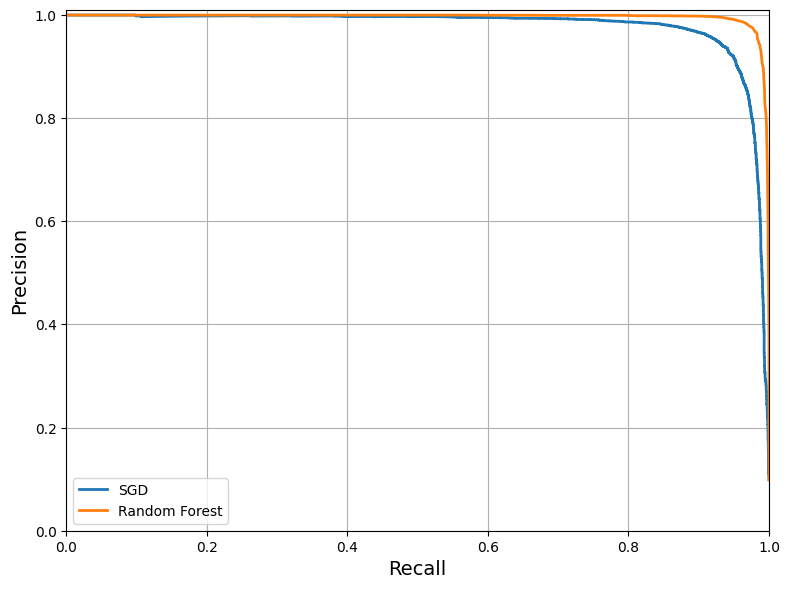

In [27]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_0, y_scores_forest)

plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, linewidth=2, label='SGD')
plt.plot(recalls_forest, precisions_forest, linewidth=2, label='Random Forest')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.01)
plt.xlabel(xlabel='Recall', size=14)
plt.ylabel(ylabel='Precision', size=14)
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [28]:
y_train_pred_forest = y_probas_forest[:,1] >= 0.5
y_train_pred_forest

array([False,  True, False, ..., False, False, False], shape=(60000,))

In [29]:
f1_score(y_train_0, y_train_pred_forest)

0.9697126585555268

In [30]:
roc_auc_score(y_train_0, y_scores_forest)

0.9994553136100529

In [31]:
precision_score(y_train_0, y_train_pred_forest)

0.9917049064595835

In [32]:
recall_score(y_train_0, y_train_pred_forest)

0.948674658112443